# Model Evaluation and Validation
### Contents

1. Introduction + misclassification error  
2. Evaluation metrics  
    1. Accuracy
    2. Precision & Recall
    3. $F_1$ and $F_\beta$ scores
3. The ROC curve  
4. Metrics for regression  
    1. $R_2$ score
5. Model selection: detecting and fixing errors  
    1. Cross validation
    2. Learning curves
    3. Grid search
6. Formalization of some concepts from the book of Thomas Mitchell
    1. Confidence intervals for discrete-valued hypothesis
    2. Error estimation

## Introduction

The first question we need to ask ourselves is "***How well our model is doing?***". This question can be answered trough the use of metrics. That will lead us to a second question: "***How do we improve the model based on these metrics?***".

This chapter presents some statistical methods focusing on these questions:
1. Given the observed accuracy of a hypothesis $h$ (a **model**) over a limited sample of data, how well does this estimate its accuracy over additional data examples?
2. Given that an hypothesis $h$ outperforms another $h'$ over some sample data, how probable is that $h$ is more accurate in general?
3. When data is limited, what is the best way to use it to both learn a hypotesis $h$ and estimate its accuracy?

These questions arise from the fact that a limited dataset might misrepresent the general underlying distribution of data. Statistical methods (together with assumption about the underlying distribution) allow to bound the difference between observed accuracy and the true accuracy over the entire distribution.

There are many **reasons** why we should evaluate a model. In many applications it is important to understand as precisely as possible the accuracy of the learned hypothesis (e.g. a model to predict the effectiveness of different medical treatments). Furthermore, in many learning methods, hypothesis evaluation is an integral step of the method itself, for example, when post-pruning a decision tree, the impact of a possible pruning step has to be evaluated.

When we train the model over a limited dataset, two main factors arise **in the estimate of the hypothesis accuracy**:
- **Bias in the estimate** (prediction bias): when the learner considers a very wide hypothesis space, it faces the risk of constructing a model that performs well on the training examples but fails to generalize over new data (because few training data failed to provide meaningful information about the underlying distribution). This fact typically happens when the learner considers a very wide hypothesis space. The model accuracy over the training set (i.e. how does it perform over the same data that have been used to training it) is a **biased estimate** of its accuracy over future examples. For this reason we should evaluate the hypothesis on a **test set** chosen independently of the training examples and the hypothesis. Remember: NEVER use the test set to train the model.

$$\text{prediction bias} = \text{average of predictions} - \text{average of true target values in the data set}$$

- **Variance in the estimate** (prediction variance): even if the hypothesis accuracy is measured over an unbiased set of test examples, the measured accuracy can still vary from the true accuracy, depending on the makeup of the test set. The smaller the test set, the greater the expected variance.

More on these two concepts in the section "From the book: 'Machine Learning' by Thomas Mitchell".

## Exercise: evaluate the model performance on a test set
- **Loading data:** Data can be read using the command `read_csv("file_name.csv")` from the [Pandas](https://pandas.pydata.org/) Python library. After loading the dataframe, we can extract columns from it, and putting them into numpy arrays:`X = np.array(data[['x1','x2']])`.

- **Training model:** Training of the model can be done using classifiers provided within the [scikit-learn](https://scikit-learn.org) library.

- **Evaluating the model:** Evaluation of the model can be done by testing the model with new data. `scikit-learn` classifiers have a `score()` method that can be used to evaluate the model. Remember this rule: ***never use testing data for training***.

Accuracy of the predictions = 0.8


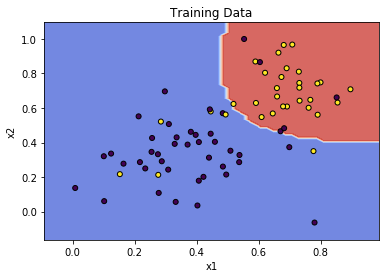

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Import statements for the classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Read the data
data = pd.read_csv('datasets/model_evaluation/data.csv')

# Split the data into input X and target y
X = np.array(data[['x1', 'x2']])
y = np.array(data['y'])

# Split the data into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Define a classifier
# classifier = LogisticRegression(solver='liblinear')
# classifier = MLPClassifier()
# classifier = DecisionTreeClassifier()
classifier = SVC(kernel='poly', degree=2, gamma='scale')

# Fit the classifier to the data
classifier.fit(X_train, y_train)
# Evaluate the model
print('Accuracy of the predictions = {}'.format(classifier.score(X_test, y_test)))

# Plot data and decision boundaries
x_min, x_max = X_train[:, 0].min() - .1, X_train[:, 0].max() + .1
y_min, y_max = X_train[:, 1].min() - .1, X_train[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) # predict Z for every point of the meshgrid
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=y_train, s=25, edgecolor='k')
plt.title('Training Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Evaluation metrics
## Confusion matrix
A tool to evaluate the performances of our classification model is the **confusion matrix**. A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a matrix in which each row represents the instances in a predicted class while each column represents the instances in an actual class. For a binary classification problem, the correctly classified instances take the name of *true positives/negatives*, while the wrong ones take the name of *false positives/negatives*.<br>
Consider the following example of a simple binary classification problem in which we predict a positive value for the data points above our curve, and a negative value fot the points below it:
<img src="images/model-evaluation/confusion-matrix.png" alt="Simple classification" style="width: 30%;"/>
The confusion matrix turns out to be:

|                  | Positive | Negative |
|------------------|----------|----------|
| Guessed positive | 6        | 2        |
| Guessed negative | 1        | 5        |

## Accuracy
Accuracy is used to measure how good a model is. Accuracy answers to the question: among all the instances, how many did we classify correctly? The answer is the ratio between the number of correct predictions and the total number of instances. In our binary classification example:

$$\frac{\text{correct predictions}}{\text{total predictions}}=\frac{6+5}{14}=78.57\%$$

Accuracy can be easily evaluated in `scikit-learn` using the `accuracy_score()` function.
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

Accuracy can be a misleading metric for imbalanced datasets (sets in which the target variable distribution is far to be uniform). Consider a binary classification problem in which we want to predict whether a tumor is malignant (positive class) or benign (negative class), over a dataset with 100 instances, respectively classified as follows:

|                  | Positive | Negative |
|------------------|----------|----------|
| Guessed positive | 1        | 8        |
| Guessed negative | 1        | 90       |

The accuracy of our model is:
$$\frac{TP + TN}{TP + TN + FP + FN} = \frac{1+90}{1+90+1+8} = 0.91$$

We correctly predicted 91% of our examples, actually doing a great job in classifying benign tumors (90 benign tumors over 91 have been correctly classified). Anyway, over the 9 malignant tumors, only 1 of them has been correctly classified, a terrible outcome, as 8 out of 9 malignancies went undiagnosed!

Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, like this one, where there is a significant disparity between the number of positive and negative labels.

**Example:** In the game of roulette, there are 38 slots, and the ball can end up on one of these slots. An ML model, by using visual features, correctly predicts the landing slot with an accuracy of 5%. Is this a good model? Yes, it is, because a random guess would be correct 1/38 of the time yelding an accuracy of 2.63% which is lower than the model's accuracy.

**Example:** A virus afflicts 0.01% of the population (1 person every 10'000). An ML model, using symptoms as inputs, predicts if a person has the virus with an accuracy of 99.99%. Is this a good model? No, because even a dumb model that always predicts a negative outcome would have that precision, but it would be useless to identify positive cases.

## Precision and Recall
[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are two metrics that can be used to evaluate a model. Some models prefer high precision (e.g. a spam classifier) while others prefer high recall (e.g. a medical model to classify sick patients).<br>

**Precision** is the answer to the question: *out of all the data points predicted to be positive, how many of them were actually positive?*
Precision is given by the ratio between the correctly classified positive instance and the total number of true and false positives.

$$\frac{\text{true positives}}{\text{true positives + false positives}}=\frac{6}{6+2}=75.00\%$$

In other words, when the model classifies a data point as positive, it is correct 75% of the time.

**Note:** a model that does not produce any false positive has a precision of 1.0.


**Recall** answers to the question: *out of the data points that are labeled positive, how many of them do we correctly predicted as positive?*

$$\frac{\text{true positives}}{\text{true positives + false negatives}}=\frac{6}{6+1}=85.71\%$$

In other words, it correctly classifies 85.71% of all positive data points.

**Note:** a model that does not produce any false negative has a recall of 1.0.

To evaluate the effectiveness of a model, we should examine both precision and recall. Unfortunately, these 2 metrics are often in tension: improving one reduces the other.

### F<sub>1</sub> score
Precision and recall can be combined into a single metric called [$F_1$ score](https://en.wikipedia.org/wiki/F1_score), which is the harmonic mean between precision and recall. That value tends to be closer to the smaller one.

$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### F<sub>$\beta$</sub> score
If we have a model that prefer precision over recall (or viceversa), then we can use the $F_\beta$ score.

$$F_\beta = (1+\beta^2) \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}$$

Note that:
- if $\beta = 0$ then we get **precision**.
- if $\beta \rightarrow +\infty$ then we get **recall**.
- if $\beta = 1$ then we get the **harmonic mean** of precision and recall.

## ROC curve
A receiver operating characteristic curve, or [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

<img src="images/model-evaluation/roc-curve-1.png" alt="Binary classification" style="width: 60%;"/>
<img src="images/model-evaluation/roc-curve-2.png" alt="ROC curve" style="width: 30%;"/>

## Metrics for regression
**Mean absolute error** and **mean squared error** are metrics to evaluate regression models and can be easily evaluated using `scikit-learn`.
```python
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

classifier = LinearRegression()
y_pred = classifier.fit(X, y_true)
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
R2 = r2_score(y, y_pred)
```
### R2 score
R2 score is defined as:

$$ R2 = 1-\frac{\text{MSE of our model}}{\text{MSE of the simplest model for our problem}}$$

If our model isn't very good, the MSE should be similar to the one of the simplest one, and so their ratio would result close to 1, so the whole R2 score should be close to 0. On the contrary, if our model is a good model, the ratio should be close to zero, and so the whole R2 score should be close to 1.

# Model selection: detecting and fixing errors
The main two errors that occours in machine learning projects are ***underfitting and overfitting***. **Underfitting** is some sort of oversimplification of the problem, and a typical symptom of this phenomenon is that our model doesn't perform well on the training set. We call this type of error an error due to bias. On the other hand, **overfitting** is some sort of overcomplication of the model. When this happens, the model does well in the training set, but it tends to memorize it instead of learning its characteristics. We call this type of error an error due to variance. Our goal is to obtain a model with a low rate of error both in the training set and in the test set.

We must remember to never use our testing data for training, since the model would obtain a perfect score in predicting the labels of data that it has already seen, but it would fail to predict anything useful on yet-unseen data (situation of overfitting). We can split our dataset: instead of just having a **training set** and a **test set**, we add a **cross validation set**. Now, the training set will be used to train the parameters, the cross validation set will be used for making decisions about the model, such as the polynomial degree, and the testing set will be used for the final testing of the model.
### Cross validation
Cross validation is a statistical method used to estimate the skills of a model. A type of cross validation technique is the ***k-fold cross validation***. The idea behind to this method is to split our dataset into *k* buckets after having randomly shuffled it in order to remove any hint of a bias. Then for each bucket, we consider it as the test set, and the remaining ones as training set. After that, we train our model using the training set (i.e. using $k-1$ of the folds), we evaluate it using the test set, we retain the evaluation score and discard the model. The performance measure reported by *k*-fold cross-validation is then the average of the values computed in the loop.

In [7]:
from sklearn.model_selection import KFold
X = range(12)
kf = KFold(n_splits=3, shuffle=True)
for train, test in kf.split(X):
    print(train, test)

[ 0  2  3  4  5  7  8 11] [ 1  6  9 10]
[ 0  1  4  5  6  9 10 11] [2 3 7 8]
[ 1  2  3  6  7  8  9 10] [ 0  4  5 11]


### Learning curves
A learning curve is a plot of model learning performance over experience or time. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves. Learning curves of model performance on the train and validation dataset can be used to diagnose an underfit, overfit, or well-fit model.

Let's consider 3 different models, respectively, one that underfits the data, one that is ok, and one that overfits the data. We can plot, for each of the three models, the training error and the cross validation error as the number of training points varies.
<img src="images/model-evaluation/learning-curves.png" alt="Learning curves" style="width: 70%;"/>
The training learning curve gives an idea of how well the model is learning. The validation learning curve gives an idea of how well the model is generalizing.

**High validation errors** indicate a **bias problem**, but they don't give the directionality of the bias, which can instead be guessed from the training error:
- A **high training error** indicates **high bias** (underfitting model).
- A **low training error** indicates **low bias** (overfitting model).

The **variance** of the model can be estimated in at least two ways:
- By looking at the **gap** between the validation learning curve and the training learning curve. Generally, **the more narrow the gap, the lower the variance** and the wider the gap, the greater the variance. High variance means that the model fits the data too well and will have problem generalizing on new unseen data.
- By examining the training error evolution as the training set size increases.

Note that if we talk about score, instead of error, these are opposite, so the higher the error, the lower the score. Thus, when you see the curve, you need to flip it upside down in your mind, in order to compare it with the curves above.


In [2]:
from sklearn.model_selection import learning_curve

# It is good to randomize the data before drawing Learning Curves
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2

# Procedure to draw the learning curves of a certain model
def draw_learning_curves(X, y, estimator, num_trainings, estimator_name):
    X2, y2 = randomize(X, y)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X2, y2, cv=3, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves: {}".format(estimator_name))
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()

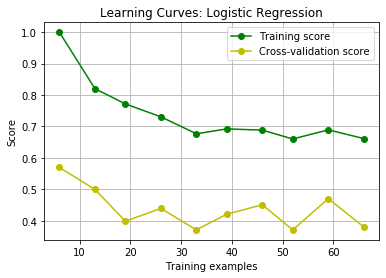

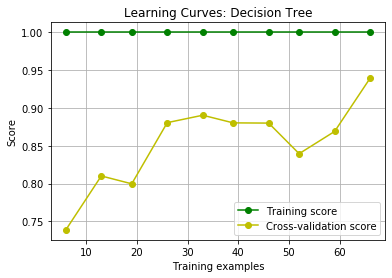

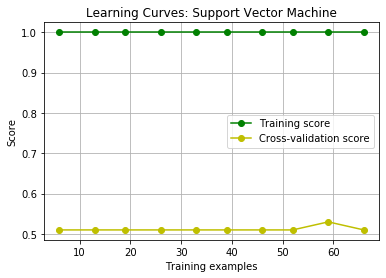

In [3]:
# Import, read, and split data
import pandas as pd
data = pd.read_csv('datasets/model_evaluation/data_learning_curve.csv')
import numpy as np
X = np.array(data[['x1', 'x2']])
y = np.array(data['y'])

# Fix random seed
np.random.seed(55)

### Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

### Logistic Regression
estimator_LR = LogisticRegression(solver='liblinear')

### Decision Tree
estimator_GBC = GradientBoostingClassifier()

### Support Vector Machine
estimator_SVC = SVC(kernel='rbf', gamma=1000)

draw_learning_curves(X, y, estimator_LR, 10, 'Logistic Regression')
draw_learning_curves(X, y, estimator_GBC, 10, 'Decision Tree')
draw_learning_curves(X, y, estimator_SVC, 10, 'Support Vector Machine')

The last example shows how three different classifiers perform differently on the same dataset:
1. **Logistic Regression:** Underfits (low training and testing score, so we will not benefit much from more training data).
2. **Decision Tree:** It's ok (high training and testing score).
3. **Support Vector Machine:** Overfits (high training score, low testing score).


Indeed, we can check it by visualizing the estimators:

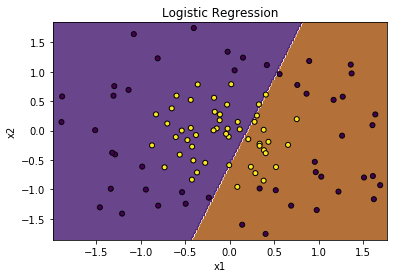

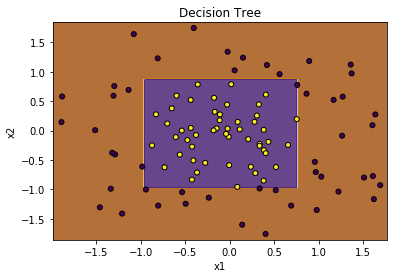

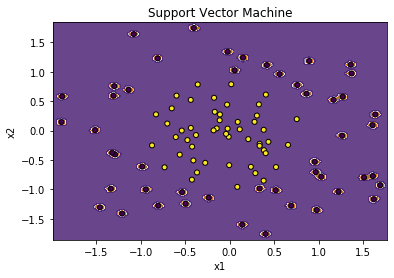

In [4]:
def plot_estimator(X, y, estimator, estimator_name):
    # Fit the classifier to the data
    estimator.fit(X,y)

    # Plot data and decision boundaries
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()]) # predict Z for every point of the meshgrid
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.PuOr, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], marker='o', c=-y, s=25, edgecolor='k')
    plt.title(estimator_name)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    
plot_estimator(X, y, estimator_LR, 'Logistic Regression')
plot_estimator(X, y, estimator_GBC, 'Decision Tree')
plot_estimator(X, y, estimator_SVC, 'Support Vector Machine')

## Grid search
Grid-search is a method to understand which combination of hyperparameter values is optimal (in the sense that maximizes a performance score) for training a model, by performing an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm.. In other words, grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.

For instance, when training a SVM classifier we typically have some hyperparameters to set, like the **kernel** which can be *linear* or *polynomial*. Another hyperparameter is the **gamma** parameter. Combining a subset of values for each of these two parameters, we'll obtain a grid which contains, in each of its cells, the F1 score (for instance). The combination of hyperparameters that leads to the highest F1 score, is the one we will select for our model.

<img src="images/model-evaluation/grid-search.png" alt="Search grid" style="width: 40%;"/>

### Grid search in scikit-learn

```python
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

scorer = make_scorer(f1_score)
parameters = {'kernel':['poly', 'rbf'],'C':[0.1, 1, 10]}
# Create the object
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# Fit the data
grid_fit = grid_obj.fit(X, y)
# Get the best estimator
best_clf = grid_fit.best_estimator_
```

# From the book: 'Machine Learning' by Thomas Mitchell (PP. 128-152)
Consider the following setting for a learning problem, in which we want to learn a target function
$$f:X\rightarrow Y$$
where:
- $X$ is the space of possible instances
- $Y$ is the space of target values
- $D$ is an unknown probability distribution of the instances $x\in X$. Note that $D$ says nothing about the target value of an instance $x$.

The learning task is to learn the target function $f$ by considering a space $H$ of possible hypothesis. Training examples are provided to the learner by drawing each instance $x$ (together with its correct target value $f(x)$) independently, according to the distribution $D$.

Let's try to answer these questions:
1. Given an hypothesis $h$ and a data sample containing $n$ examples drawn at random according to $D$, what is the best estimate of $h$'s accuracy over future instances drawn from the same distribution?
2. What is the probable error in this accuracy estimate?

**Definition:** The **sample error** of a hypothesis with respect to a sample $S$ of instances drawn randomly from $X$ is the fraction of $S$ that it misclassify.

$$error_S(h) \equiv \frac{1}{n}\sum_{x\in S}{\delta\left(f(x),h(s)\right)}$$

where $\delta(f(x),h(s)) = 1$ if $h(x)\neq f(x)$, 0 otherwise.

**Definition:** The **true error** of a hypothesis is the probability that it will misclassify a singe instance drawn from the distribution $D$.

$$error_D(h) = Pr_{x\in D}[f(x)\neq h(x)]$$

## Confidence intervals for discrete-valued hypothesis

We want to answer the question "*How good an estimate of $error_D(h)$ is provided by $error_S(h)$?*" for a **discrete-valued hypotesis**.

**[Confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval)** are interval estimators that propose a range of plausible values for an unknown parameter ($error_D(h)$). An interval has an associated probability (confidence level) that the true parameter lies within the interval. So, a $N\%$ confidence interval estimate for parameter $p$ is an interval that includes $p$ with probability $N\%$.

Recall that $error_S(h) = r/n$, where $n$ is the number of samples in $S$ drawn randomly according to $D$ and $r$ is the number of errors committed by $h$ over the $n$ samples.

1. Given no information, the most probable value of $error_D(h)$ is $error_S(h)$.
2. With approximately 95% probability, the true error $error_D(h)$ lies in the interval

$$error_S(h) \pm 1.96\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

This means that, if we repeat the experiment of drawing each time a new sample $S_i$ containing $n$ new samples, then, for approximately 95% of these experiments, the calculated interval would contain the true error $error_D(h)$. That interval is called the 95% confidence interval estimate for $error_D(h)$.

More generally, the $N\%$ confidence interval estimate for $error_D(h)$ is

$$error_S(h) \pm z_N\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

where $z_N$ depends on the desired confidence level (this formula will be derived in the following sections).

This is true under these assumptions:
- $h$ is a discrete-valued hypotesis (model).
- $S$ is drawn at random using the same distribution from which future data will be drawn.
- $S$ is independent from the training data used for generating $h$ (the data is independent from the hypothesis being tested).

In general, this approximation is good when $n\ge30$ and $error_S(h)$ is not too close to 0 or 1. A general rule of thumb is that $n\cdot error_S(h)(1 - error_S(h)) \ge 5$.

## Error estimation
We ask ourserlves "***how does the deviation between the sample error and the true error depends on the size of the sample?***". More generally, this question is an instance of the problem of estimating the proportion of a **population** that exhibits some properties (e.g. the property that $h$ will misclassify an example), given the observed proportion over some random **sample of the population**. <br>
Assume that we repeat the experiment of drawing each time a new sample $S_i$ of size $n$. Then, $error_{S_i}(h)$, the outcome of the *i*-th experiment, is a **random variable** whose values are the observed outcomes of the many experiemnts. If we repeat the experiment a large number of times, our random variable will behave like a **[Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)**.

<img src='images/model-evaluation/binomial.jpg' alt="Binomial distribution" style="width: 40%;"/>

$$P(r)=\frac{n!}{r!(n-r)!}p^r(1-p)^{n-r}$$

If $X$ is a random variable that follows a Binomial distribution, then $Pr(X=r)=P(r)$. Its mean, variance and standard deviation are, respectively:

$$E[X]=np, \qquad Var(X)=np(1-p) \qquad \sigma_X = \sqrt{Var(X)}$$

Consider the example of a coin being toss: the binomial distribution gives the probability of observing $r$ heads in an example of $n$ independent coin tosses, when the probability of heads on a single coin toss is $p$.

Now, suppose that we don't know $p$: we can toss the coin $n$ times, record the number of times $r$ that we obtained head. A reasonable estimate for $p$ is $p=r/n$. If the experiment were rerun, $r$ might be different, yelding a different estimate of $p$.

The Binomial distribution describes for each possible value of $r$ (i.e., from 0 to $n$), the probability of observing exactly $r$ heads given a sample of $n$ independent tosses of a coin, whose true probability of heads is $p$. Estimating $p$ from a random sample of coin tosses is equivalent to estimating $error_D(h)$ from testing $h$ on a random sample of instances.

A single toss of the coin is equivalent to drawing a single instance form $D$ and determining whether it is misclassified by $h$, and so $p$ corresponds to the probability that a single instance randomly drawn will be misclassified ($p=error_D(h)$).

The number $r$ of heads observed over a sample of $n$ coin tosses corresponds to the number of misclassifications observed over $n$ randomly drawn instances. Thus $r/n$ corresponds to $error_S(h)$.

The Binomial distribution depends on the specific sample size $n$ and the specific probability $p$ or $error_D(h)$.

Now, let's return to the question: ***What is the likely difference between $error_S(h)$ and the true error $error_D(h)$?*** Let's call:

$$error_S(h)=\frac{n}{r} \qquad error_D(h)=p$$

$error_S(h)$ is an **estimator** for $error_D(h)$. The **estimation bias** of an estimator $Y$ for a parameter is the difference between the expected value of the estimator and the parameter's true value $p$.

$$\text{Estimation bias } = E[Y] - p$$

If the estimation bias is zero, then $Y$ is an **unbiased estimator** for $p$. $error_S(h)$ is an unbiased estimator of $error_D(h)$, indeed, $E[error_S(h)]=E[n/r]=p$ (because $n$ is constant and $r$ follows a Binomial distribution).

**Take home message:** In order for $error_S(h)$ to give an unbiased estimate of $error_D(h)$, the hypothesis $h$ and sample $S$ must be chosen independently. For this reason, if we train a model over a **training set**, we won't evaluate its performance on the same set used to train it, but we will do it on a different **test set**, drawn from the same underlying distribution (this means that we have to split the data we have into different sets, each used for a different task).

Given a choice among alternative unbiased estimators, choose the one with least **variance** (this choice will lead to the smallest expected squared error between the estimate and the true value of the parameter). We have said that an unbiased estimate for $error_D(h)$ is given by $error_S(h)=r/n$. The variance of this estimate arises from the variance in $r$ (because $n$ is constant) which is Binomially distributed. Its variance is $Var(r)=np(1-p)$ but $p$ is unknown. So, we substitute to $p$ our unbiased estimate $error_S(h)=r/n$, yelding:

$$\sigma_{error_S(h)} = \frac{\sigma_r}{n} = \sqrt{\frac{p(1-p)}{n}} \approx \sqrt{\frac{error_S(h)(1-error_S(h))}{n}}$$

## Confidence intervals
The confidence intervals for the parameter $error_D(h)$ can be derived from the fact that its estimator $error_S(h)$ follows a Binomial distribution, with:

$$E[error_S(h)] = error_D(h) \qquad \sigma_{error_S(h)} \approx \sqrt{\frac{error_S(h)(1-error_S(h))}{n}}$$

To derive a $N\%$ confidence interval, we have to find the interval centered around the mean value $error_D(h)$, which contains $N\%$ of the total probability under this distribution. In other words, $N\%$ of the time, the estimate $error_S(h)$ will fall within that interval sorrounding $error_D(h)$. For large $n$, any Binomial distribution is very
closely approximated by a Normal distribution with the same mean and variance.

If a random variable $Y\sim \mathcal{N}(\mu,\sigma)$, then the measured random value $y$ of $Y$ will fall into the interval $[\mu \pm z_N\sigma]$, $N\%$ of the time. Equivalently, the mean $\mu$ will fall $N\%$ of the time into the interval:

$$y\pm z_N\sigma$$ 

where $z_N$ gives half the width of the interval (i.e., the distance from the mean in either direction) measured
in standard deviations that includes $N\%$ of the total probability mass under the bell-shaped Normal distribution.

Now, if we substitute the mean and standard deviation of $error_S(h)$ into this last formula, we will find:

$$error_S(h) \pm z_N\sqrt{\frac{error_S(h)(1 - error_S(h))}{n}}$$

In deriving this expression two approximations have been made:
1. When estimating the standard deviation $\sigma$ of $error_S(h)$, we have approximated $error_D(h)$ by $error_S(h)$.
2. The Binomial distribution has been approximated by a Normal distribution.

### One sided intervals
If we were interested only in a *one-sided* bound (e.g. *What is the probability that $error_D(h)$ is at most U?*), thanks to the fact that the Normal distribution is symmetrical about its mean, any two-sided confidence interval based on a Normal distribution can be converted to a corresponding **one-sided interval with twice the confidence**. A $100(1- a)\%$ confidence interval with lower bound $L$ and upper bound $U$ implies a $100(1- a/2)\%$ confidence interval with lower bound $L$ and no upper bound.

## Comparing two hypotheses
TO-DO